# 🔊 Audio MNIST Digit Vocal Recognition
---

![](https://drive.google.com/uc?export=download&id=1RWyBGQ7fqqmKhw2dW-ZKHaFXLC8FM5K5)

Given audio digits from the **Audio MNIST dataset**, let's try to *recognize any new spoken digit.* 🤖

We will use a **Tensorflow Neural Network** and **audio features** such as *Mel-Frequency Cepstral Coefficients (MFCC)* to make the predictions. 🦾

# Getting Started

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For Audio
import librosa
import librosa.display
import IPython.display as ipd

# Scikit-learn tools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tensorflow Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Extras
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

# Parameters

These parameters are supposed to be **constant** along the notebook. The MAX parameters are used to select the files for the dataset. It is convenient for debugging and makes it possible to load a small amount of audio files. The audio parameters are basic parameters used in signal preprocessing. 👀

In [2]:
# Select audio amount
PERSON_MAX = 60 # Person number
RECORD_MAX = 50 # Record number of the person
DIGIT_MAX = 10 # Spoken digit

# Audio parameters
SR = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512

# Display Examples

The only purpose of this function is to **display the waveform and the audio player** of the different digits so you can hear how it sounds.

Notice that the audios do not have the exact same length. We will see later that it is not a problem for the predictions. 👍

In [3]:
def display_example(label):
    
    labels = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    
    # Load file
    file = f'../input/audio-mnist/data/06/{label}_06_0.wav'
    signal, sr = librosa.load(file)
    
    # Display wave
    plt.figure(figsize=(14, 2))
    librosa.display.waveshow(y=signal, sr=sr, color=plt.cm.tab10(label))
    plt.title(f"Audio {labels[label]}")
    plt.show()
    
    # Display audio
    return ipd.Audio(file)

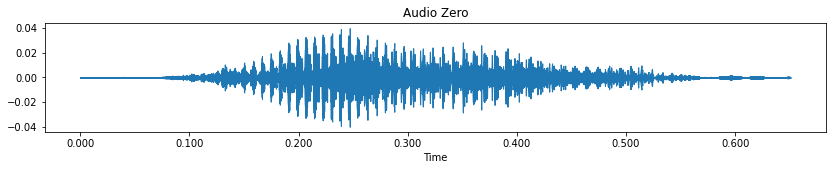

In [4]:
# Zero
display_example(0)

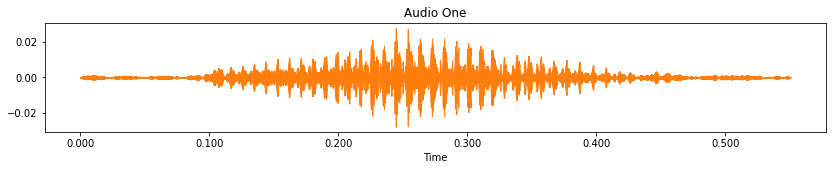

In [5]:
# One
display_example(1)

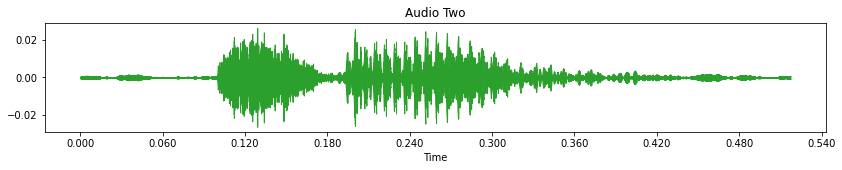

In [6]:
# Two
display_example(2)

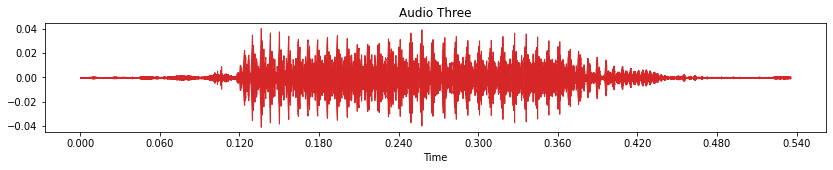

In [7]:
# Three
display_example(3)

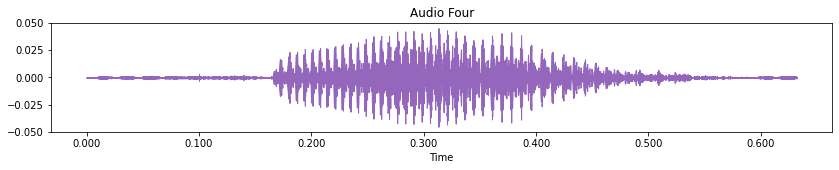

In [8]:
# Four
display_example(4)

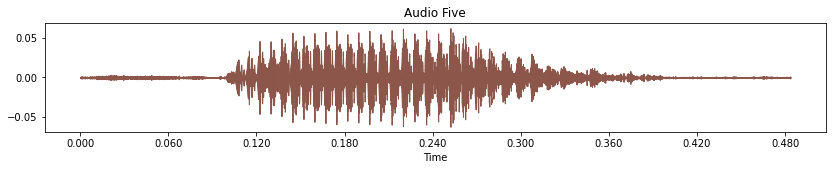

In [9]:
# Five
display_example(5)

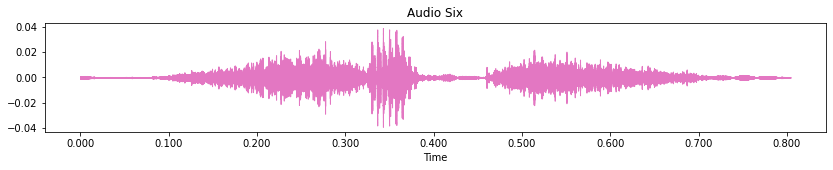

In [10]:
# Six
display_example(6)

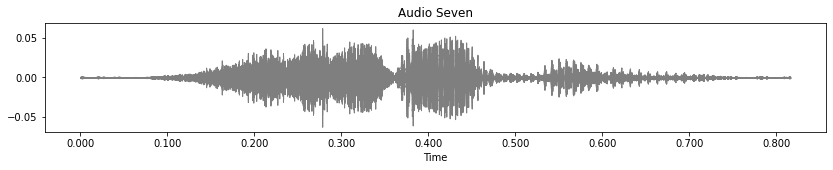

In [11]:
# Seven
display_example(7)

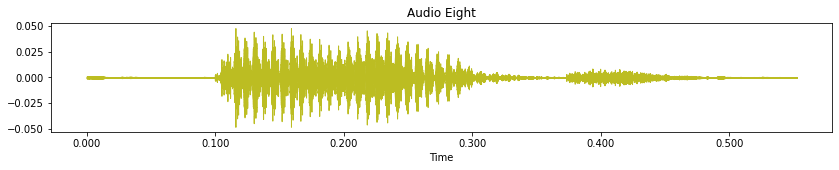

In [12]:
# Eight
display_example(8)

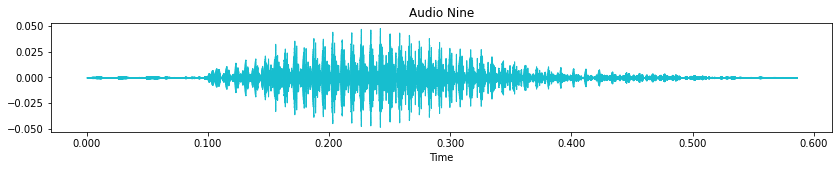

In [13]:
# Nine
display_example(9)

# Extract MFCC features

The raw audio files are **not usable like that**. What needs to be recognized is not the pitch nor the intensity of the signal. 🤔

What matters is the **timbre** of the record produced by the vocal tract of the person speaking. In audio processing, **MFCCs** are great features to describe it.

*The next function is going to **load the different files** based on the previous parameters.* Then it gets the MFCC features of the audio files which is a two-dimensional array. From this array, the mean and the variance of each MFCC number is calculated in order to reduce the number of features. Finally, the features are stored in a pandas dataframe with the associated labels. 😄

In [14]:
def extract_features():
    
    data = []
    
    # Loop over the files
    for person in tqdm(range(PERSON_MAX)):
        person += 1 # from 1 to 60
        
        for record in range(RECORD_MAX): # from 0 to 49
            
            for digit in range(DIGIT_MAX): # from 0 to 9
                
                if person < 10:
                    file = f'../input/audio-mnist/data/0{person}/{digit}_0{person}_{record}.wav'
                else:
                    file = f'../input/audio-mnist/data/{person}/{digit}_{person}_{record}.wav'
                
                # Get MFCC
                signal = librosa.load(file)[0]
                mfcc = librosa.feature.mfcc(signal, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                
                # Features
                mean = mfcc.mean(axis=1).tolist()
                var = mfcc.var(axis=1).tolist()
                features = mean + var + [digit]
                data.append(features)
    
    # Create dataframe
    cols = ['mean_' + str(x+1) for x in range(N_MFCC)] + ['var_' + str(x+1) for x in range(N_MFCC)] + ['Digit']
    df = pd.DataFrame(data, columns=cols)
                
    return df

In [15]:
# Get and save the dataframe
df = extract_features()
df.to_csv('mfccs.csv', index=False)
df

100%|██████████| 60/60 [19:43<00:00, 19.72s/it]


,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,...,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,Digit
0,-620.449890,105.183487,6.218107,29.962128,22.367586,5.238488,3.886459,-9.102861,5.492270,3.079150,...,500.548462,111.577972,141.754547,598.958557,112.851204,61.961651,98.088654,96.963745,40.897366,0
1,-666.720581,152.036270,23.814123,26.147600,16.825335,-1.239647,3.836028,-8.315078,7.226923,-3.585444,...,681.752197,827.590271,114.961464,163.406509,38.895878,56.060291,112.291786,69.958015,35.565571,1
2,-629.485779,119.914078,21.944551,28.408852,17.056271,4.751925,-6.154936,3.148486,3.209990,-5.466937,...,153.470779,65.822838,334.340363,362.898743,104.885231,176.994888,165.521484,50.891335,93.376686,2
3,-640.946533,74.883034,14.819345,51.374962,34.610458,7.415653,0.662035,-10.455687,3.184168,6.782655,...,697.327454,660.689209,124.780815,278.009521,186.938293,97.762070,196.262070,39.096283,32.341095,3
4,-618.985962,113.978859,17.164722,13.674443,1.092435,1.687511,2.810538,4.980398,-2.442796,6.951013,...,436.931366,568.970642,157.711090,63.151512,129.050583,127.000778,35.466606,46.659668,44.889870,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-596.546753,88.604362,-4.474265,23.729818,16.101854,3.292103,-18.684767,-1.265355,-0.866440,0.804766,...,246.992004,278.016449,156.136673,40.640926,50.066647,103.029076,109.519936,65.816338,104.947937,5
29996,-631.260437,11.594004,40.924374,26.058115,20.223640,13.251475,-20.202280,15.787358,-3.781508,10.370688,...,109.236778,486.175232,286.211395,49.937603,64.722130,165.481476,32.471447,17.584505,36.098152,6
29997,-653.248108,58.307636,45.860146,37.195820,24.439035,3.972988,-17.024359,12.306346,-1.619171,-1.177223,...,147.893723,406.205505,230.981049,94.296432,68.440964,89.865005,101.630234,40.329903,49.416702,7
29998,-648.223083,63.274036,28.944569,49.671341,18.823055,-6.540566,-21.066227,12.702807,-10.316767,-6.049613,...,91.015450,537.276367,239.425446,73.084641,222.426819,135.357544,28.111727,35.788006,232.352600,8


As we can see, we got a dataframe containing the **means and variances along time of all the MFCC coefficients**. At the end of it there is the label corresponding to the audio. For now, the dataframe is **not scaled**. This poses a problem for the convergence of the model. Also, the files have been loaded in a certain order and we want everything to be **shuffled** before making our **train and test sets**.

*Let's build a new function that will complete the preprocessing of our data!* 👊

# Preprocessing

First, the function splits the previous dataframe into the **features X** and the **labels y**. The train and test sets are also separated with a **80/20 proportion.** As said previously it is important to **shuffle** the data to have a certain homogeneity in the data in both sets. At the end the features are **scaled**. It is best to fit the scaler on the train set only because we must not integrate information about the test set until doing the last predictions. 😉

In [16]:
def preprocessing(df):
    
    # Split X and y
    X = df.drop('Digit', axis=1)
    y = np.array(df['Digit'])
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)
    
    # Scale X
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns).reset_index(drop=True)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns).reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

In [17]:
# Load the preprocessed sets
X_train, X_test, y_train, y_test = preprocessing(df)
X_train

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,mean_10,...,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13
0,2.074453,0.467823,-2.216180,-1.552122,-1.520270,0.801366,-1.652259,-1.679064,-0.146671,0.807506,...,-0.510122,1.213415,-1.243424,0.972836,-0.367504,-1.269776,0.242257,-0.529008,-0.882485,-0.759167
1,1.318969,0.248527,-1.768920,-1.507101,-1.515528,0.102118,0.475174,-0.324556,-0.257640,-0.458019,...,0.016347,1.405931,-0.693247,-0.135256,0.288021,-1.039310,1.441312,-0.570658,-0.351753,-0.843792
2,-0.677679,-0.049964,0.899053,1.984820,1.422706,-1.272700,-1.941981,-0.420681,2.561007,-2.085080,...,2.091722,-0.693182,0.651104,1.024038,-0.754727,-1.030792,5.935803,0.133267,-0.675500,-0.896991
3,-0.908716,0.490488,2.128877,0.500281,0.922492,1.716329,0.401137,1.250823,0.525590,-1.875638,...,0.864371,0.045416,-0.523943,0.059487,-0.747347,0.117669,0.699049,0.559280,0.047488,0.406317
4,0.123931,-0.681000,0.099048,0.200830,0.459099,1.354818,0.005902,-0.247382,-0.508831,-0.625746,...,-0.858647,1.113180,0.245147,-0.351130,-0.374535,2.302022,-0.421193,-1.071850,-0.698705,-0.118187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.773087,-0.069742,-0.240983,1.724039,1.839618,-0.715613,-0.141581,-0.388502,0.866208,0.029677,...,1.791955,-0.701179,-0.262556,-0.044161,-0.501377,-1.001606,-1.015197,1.437335,-1.189852,0.345247
23996,1.148059,-0.839970,-0.985464,1.605708,0.605560,-1.422115,-2.042625,-0.203026,1.583326,-0.363595,...,0.219035,1.135646,1.285839,3.255139,-0.724585,-0.316997,-0.134030,0.022966,-0.755463,-1.163233
23997,0.129150,0.491366,-1.485306,-1.091775,-0.361991,-0.836163,-0.549684,-1.054690,-0.082919,0.082466,...,-0.111487,-0.411617,-0.125138,0.142368,-0.296764,-1.142017,-0.628444,0.867114,-0.951340,-0.075009
23998,-0.095249,0.846056,-1.127317,0.126187,0.534431,0.222234,-0.654094,0.790051,-0.465421,-1.177444,...,-0.097830,-0.769428,-1.103721,-0.018956,-1.246877,0.117062,-0.684426,-0.823084,-0.605062,4.442629


In [18]:
y_train[:10]

array([5, 5, 8, 0, 7, 4, 6, 3, 3, 1])

Everything is ready! It is finally time to create the **prediction model!** 😄

# Create Model

Since I want to perform cross-validation, I will need several copies of the model. The best is to build a function **that creates a brand-new model** so that there is no need to write everything each time.

In [19]:
def create_model():
    
    # Model architecture
    model = Sequential()
    model.add(Dense(128, input_shape=(N_MFCC * 2,), activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Compilation
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

The model is a very simple neural network classifier that takes in input a one-dimensional vector of the MFCC means and variances.

The output is composed of **10 neurons** representing the different labels. 🕵️‍♂️

# Cross Validation

Now we will use the previous function in a new function for cross validation. For every fold, a new model is created and trained on the corresponding training set and is evaluated on the validation set. The scores are returned and we save the number of epochs of each model in order to use it for the final training. 🧐

In [20]:
def cross_val(n_splits=5):
    
    results = {'Val Scores': [], 'Last Epochs': []}
    kfold = StratifiedKFold(n_splits=n_splits)
    
    # Loop over the folds
    for train_idx, val_idx in kfold.split(X_train, y_train):
        
        # Get the train-validation sets of the fold
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
        
        # Create a new model and fit it
        model_cv = create_model()
        history = model_cv.fit(
            X_train_cv,
            y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=100,
            batch_size=32,
            callbacks=[
                EarlyStopping(
                    monitor='val_loss',
                    patience=3,
                    restore_best_weights=True
                )
            ],
            verbose=0
        )
        
        # Store the scores and the last epoch of the callbacks
        results['Val Scores'].append(model_cv.evaluate(X_val_cv, y_val_cv))
        results['Last Epochs'].append(len(history.history['loss']))
        
    return results

In [21]:
# Results
results = cross_val(n_splits=5)
print("\nValidation average accuracy: {:.2f}%\n".format(np.array(results['Val Scores']).mean(axis=0)[1] * 100))
for i in range(len(results['Last Epochs'])):
    print("Fold {} - Model last epoch: {}".format(i+1, results['Last Epochs'][i]))
best_epoch_nb = int(np.around(np.mean(results['Last Epochs'])))
print("\nAverage of epochs for final training:", best_epoch_nb)

2022-11-10 07:59:13.672601: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-10 07:59:13.829238: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


150/150 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.9875

Validation average accuracy: 98.35%

Fold 1 - Model last epoch: 7
Fold 2 - Model last epoch: 7
Fold 3 - Model last epoch: 11
Fold 4 - Model last epoch: 13
Fold 5 - Model last epoch: 14

Average of epochs for final training: 10


As we can see, the model stopped at different epochs depending on the fold. Since we use the full training set for the final model, we cannot use an early stopping on the validation loss. Then we use the best epoch number calculated by the average of the last epochs of the 5 previous models. 👌

# Final Model Training

Now it is time to train the final model on the **full training set** in order to **maximize the number of data**. We still keep the test set as validation data in order to follow the improvement of the accuracy. But it will not be used for stopping because it is the test set and it should never be used for the training. ❌

In [22]:
# Fit with full training set
model = create_model()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=best_epoch_nb,
    batch_size=32
)

Epoch 1/10
750/750 [==============================] - 3s 3ms/step - loss: 0.2554 - accuracy: 0.9212 - val_loss: 0.0839 - val_accuracy: 0.9718
Epoch 2/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0735 - accuracy: 0.9763 - val_loss: 0.0563 - val_accuracy: 0.9788
Epoch 3/10
750/750 [==============================] - 2s 2ms/step - loss: 0.0544 - accuracy: 0.9818 - val_loss: 0.0561 - val_accuracy: 0.9798
Epoch 4/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.0466 - val_accuracy: 0.9838
Epoch 5/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0535 - val_accuracy: 0.9830
Epoch 6/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0299 - accuracy: 0.9895 - val_loss: 0.0358 - val_accuracy: 0.9877
Epoch 7/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0226 - accuracy: 0.9926 - val_loss: 0.0449 - val_accuracy: 0.9847
Epoch 

# Leaning Curves

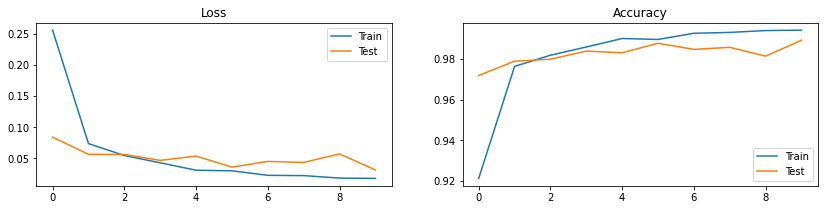

In [23]:
plt.figure(figsize=(14, 3))

plt.subplot(121)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Test")
plt.title("Loss")
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Test")
plt.title("Accuracy")
plt.legend()

plt.show()

# Confusion Matrix

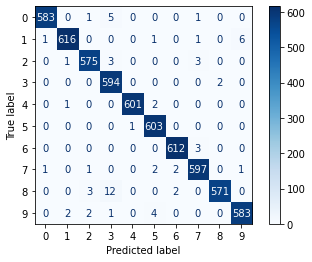

In [24]:
y_pred = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# The End

Here we go! We got a very good score with this digit recognitions by using MFCC features!

Thank you for reading until the end. Let me know if you have any question or suggestion about my work. 😄

**Have a nice day and keep learning!**